## **Music Genre Recognition**

## **Libraries**

In [ ]:
import numpy as np
import torch
import time
import random
import pandas as pd
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from sklearn.metrics import f1_score, confusion_matrix
from matplotlib import pyplot as plt
from torchvision import models
from torchsummary import summary
from pandas import DataFrame as df
import seaborn as sns

## **Feedforward Neural Network**

**Step 1: Load data**

In [2]:
# load datasets
# need to be in the same path as the notebook
x_train = np.load('./music_genre_data_di/train/mfccs/X.npy')
l_train = np.load('./music_genre_data_di/train/mfccs/labels.npy')

x_val   = np.load('./music_genre_data_di/val/mfccs/X.npy')
l_val   = np.load('./music_genre_data_di/val/mfccs/labels.npy')

x_test  = np.load('./music_genre_data_di/test/mfccs/X.npy')
l_test  = np.load('./music_genre_data_di/test/mfccs/labels.npy')

In [3]:
# map string labels to integer labels
labels, y_train = np.unique(l_train, return_inverse=True)
_,      y_test  = np.unique(l_test, return_inverse=True)
_,      y_val   = np.unique(l_val, return_inverse=True)

# create datasets
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train).long()
train_ds       = TensorDataset(x_train_tensor, y_train_tensor)

x_val_tensor   = torch.Tensor(x_val)
y_val_tensor   = torch.Tensor(y_val).long()
val_ds         = TensorDataset(x_val_tensor, y_val_tensor)

x_test_tensor  = torch.Tensor(x_test)
y_test_tensor  = torch.Tensor(y_test).long()
test_ds        = TensorDataset(x_test_tensor, y_test_tensor)

In [4]:
# create dataloaders
dl_train = DataLoader(train_ds, batch_size=16, shuffle=True)
dl_val   = DataLoader(val_ds,   batch_size=16, shuffle=True)
dl_test  = DataLoader(test_ds,  batch_size=16, shuffle=False)

**Step 2: Neural Network Architecture**

In [5]:
import torch.nn.functional as F

layer_sizes = [26, 128, 32, 4]

# Define the activation functions per layer (can be None for linear)
activations = [None, None, None]

In [6]:
class feed_forw_nn(nn.Module):
    def __init__(self, layer_sizes = layer_sizes, activations=None):
        super(feed_forw_nn, self).__init__()
        
        self.layers      = nn.ModuleList()
        self.activations = activations
        
        # create the layers based on the layer_sizes list
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        
        # default to None activation if not provided
        if self.activations is None:
            self.activations = [None] * (len(layer_sizes) - 1)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            if self.activations[i] is not None:
                x = self.activations[i](x)
        return x

**Step 3: Training Routine per epoch**

In [7]:
# Training routine
def train_epoch(model, optimizer, dataloader, loss_fn):

    for _, (inputs, labels) in enumerate(dataloader):

        # move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # reset loss for batch
        loss = 0

        def closure():
            nonlocal loss

            # zero gradient
            optimizer.zero_grad()

            # make prediction
            output = model(inputs)

            # compute loss
            loss = loss_fn(output, labels)

            # compute gradients
            loss.backward()
            return loss

        # adjust weights
        optimizer.step(closure)

**Step 4: Testing Routine**

In [8]:
def test_nn(model, dataloader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs    = model(inputs)
            test_loss += loss_fn(outputs, labels).item()
            preds      = outputs.argmax(dim=1, keepdim=True)
            correct   += preds.eq(labels.view_as(preds)).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    

    test_loss  /= len(dataloader.dataset)
    accuracy    = correct / len(dataloader.dataset)
    
    all_preds   = np.array(all_preds)
    all_labels  = np.array(all_labels)
    f1_macro    = f1_score(all_labels, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return test_loss, f1_macro, accuracy, conf_matrix

**Step 5: Train model**

It is important to note that we find the best performing model version (depending on the epoch) from this step, and not at step 7.

Note that we can remove the code following the `# save the best performing model` comment and return `model` instead of `best_model` in order to return the final model.

In [9]:
def train_nn(model, num_epochs, optimizer, train_loader, test_loader, loss_fn, scheduler=None, sch_step=False):
    val_losses     = list()
    val_scores  = list()
    val_accuracies = list()

    tr_losses     = list()
    tr_scores     = list()
    tr_accuracies = list()

    # save the best performing model
    best_f1_macro = 0

    best_model = type(model)().to(device)

    start = time.time()
    for _ in range(num_epochs):

        # train model on this epoch
        train_epoch(model, optimizer, train_loader, loss_fn)

        # validate model
        test_loss, f1_macro, accuracy, conf_matrix = test_nn(model, test_loader, loss_fn)
        val_losses.append(test_loss)
        val_scores.append(f1_macro)
        val_accuracies.append(accuracy)

        train_loss, f1_train, acc_train, _ = test_nn(model, train_loader, loss_fn)
        tr_losses.append(train_loss)
        tr_scores.append(f1_train)
        tr_accuracies.append(acc_train)
        
        # save the best performing model
        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_model.load_state_dict(model.state_dict())

        if scheduler is not None:
            if sch_step: scheduler.step(test_loss)
            else:        scheduler.step()

    end = time.time()

    print("Done in {:.2f} seconds using {}".format(end - start, 'GPU' if torch.cuda.is_available() else 'CPU'))

    return best_model, tr_losses, val_losses, range(1, num_epochs + 1), tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix

In [10]:
def plot_results(train_losses, test_losses, epochs, train_f1_scores, test_f1_scores, train_accuracies, test_accuracies, conf_matrix):
    plt.figure(figsize=(18, 5))

    # Plot Loss
    plt.subplot(1, 4, 1)
    plt.plot(epochs, train_losses, 'b', label='Train Loss')
    plt.plot(epochs, test_losses, 'r', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1 Macro
    plt.subplot(1, 4, 2)
    plt.plot(epochs, train_f1_scores, 'b', label='Train F1 Macro')
    plt.plot(epochs, test_f1_scores, 'r', label='Validation F1 Macro')
    plt.title('F1 Macro over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Macro')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 4, 3)
    plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Confusion Matrix
    plt.subplot(1, 4, 4)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

Done in 9.15 seconds using GPU


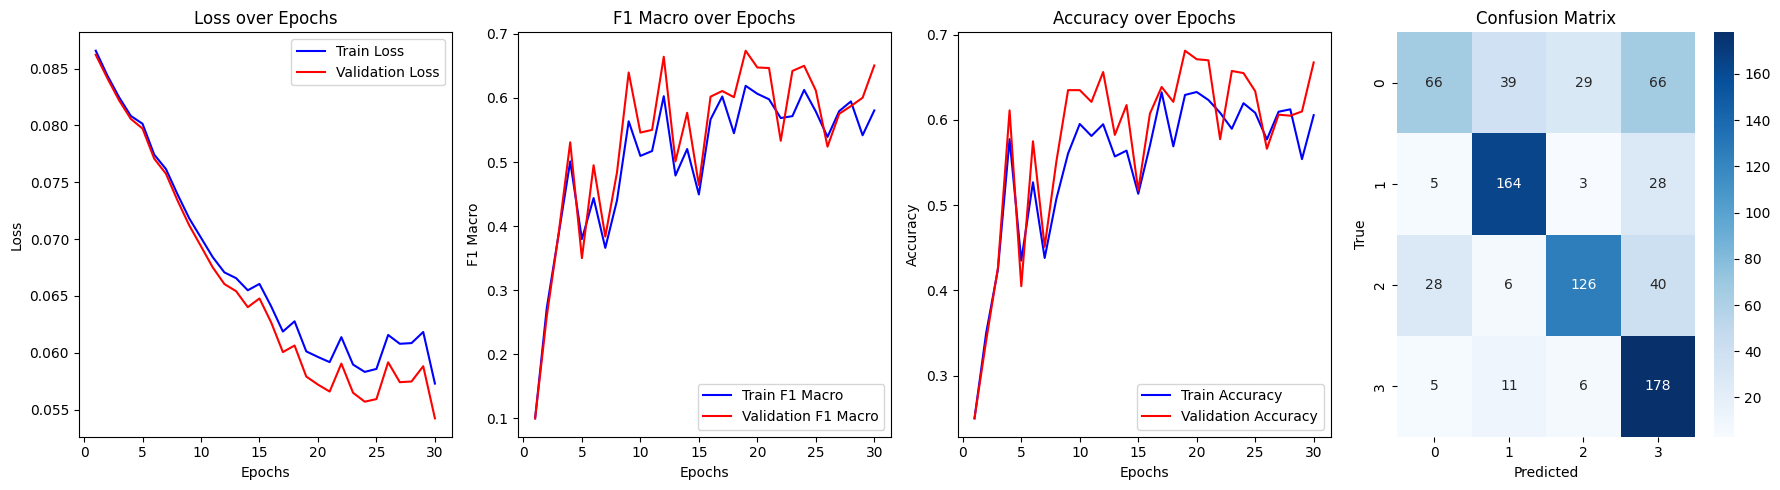

In [11]:
device = 'cpu'
model = feed_forw_nn(layer_sizes, activations).to(device)

learning_r = 0.002
epochs_n   = 30
optimizer  = optim.SGD(model.parameters(), lr=learning_r)
loss_fn    = nn.CrossEntropyLoss()

# best_model, tr_losses, val_losses, range(1, num_epochs + 1), tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix
best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [12]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_test, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.06113026922482044
Test F1 Macro: 0.6034375606673241
Test Accuracy: 0.6155523255813954
Test Confusion Matrix:
 [[ 93  32  87 112]
 [ 30 237  11  19]
 [ 63  15 247  31]
 [ 46  34  49 270]]


**Step 6: Use GPU**

Done in 15.85 seconds using GPU


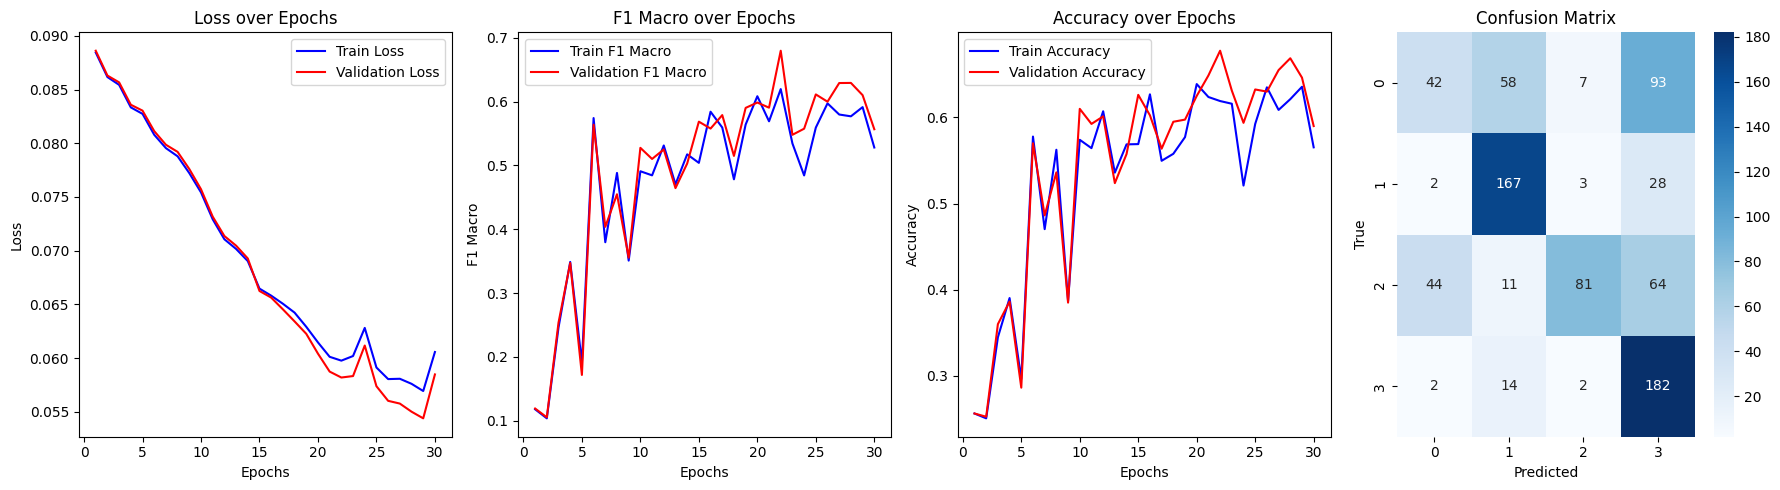

In [13]:
device = 'cuda'
model = feed_forw_nn(layer_sizes, activations).to(device)

learning_r = 0.002
epochs_n   = 30
optimizer  = optim.SGD(model.parameters(), lr=learning_r)
loss_fn    = nn.CrossEntropyLoss()

# best_model, tr_losses, val_losses, range(1, num_epochs + 1), tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix
best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Step 7: Select the best model**

In [ ]:
# done at step 5

## **Convolutional Neural Network**

**Step 1: Load data**

In [14]:
# load datasets
x_train = np.load('./music_genre_data_di/train/melgrams/X.npy')
l_train = np.load('./music_genre_data_di/train/melgrams/labels.npy')

x_val   = np.load('./music_genre_data_di/val/melgrams/X.npy')
l_val   = np.load('./music_genre_data_di/val/melgrams/labels.npy')

x_test  = np.load('./music_genre_data_di/test/melgrams/X.npy')
l_test  = np.load('./music_genre_data_di/test/melgrams/labels.npy')

In [15]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(3200, 21, 128)
(800, 21, 128)
(1376, 21, 128)


In [16]:
# Add dimension For channel
x_train = x_train.reshape(3200, 1, 21, 128)
x_val   = x_val.reshape(800, 1, 21, 128)
x_test  = x_test.reshape(1376, 1, 21, 128)

# map string labels to integer labels
labels, y_train = np.unique(l_train, return_inverse=True)
_,      y_test  = np.unique(l_test, return_inverse=True)
_,      y_val   = np.unique(l_val, return_inverse=True)

In [17]:
# convert to pytorch tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train).long()
train_ds       = TensorDataset(x_train_tensor, y_train_tensor)
dl_train       = DataLoader(train_ds, batch_size=16, shuffle=True)

x_val_tensor = torch.Tensor(x_val)
y_val_tensor = torch.Tensor(y_val).long()
val_ds       = TensorDataset(x_val_tensor, y_val_tensor)
dl_val       = DataLoader(val_ds,   batch_size=16, shuffle=True)

x_test_tensor  = torch.Tensor(x_test)
y_test_tensor  = torch.Tensor(y_test).long()
test_ds        = TensorDataset(x_test_tensor, y_test_tensor)
dl_test        = DataLoader(test_ds,  batch_size=16, shuffle=False)

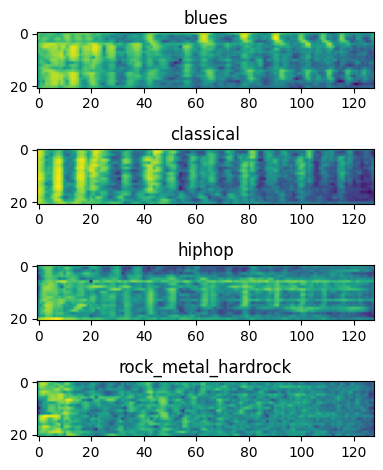

In [18]:
# visualize melgrams
plt.subplot(4, 1, 1).imshow(x_test_tensor[0].reshape(21, 128))
plt.subplot(4, 1, 1).set_title(labels[y_test_tensor[0]])
plt.subplot(4, 1, 2).imshow(x_test_tensor[500].reshape(21, 128))
plt.subplot(4, 1, 2).set_title(labels[y_test_tensor[500]])
plt.subplot(4, 1, 3).imshow(x_test_tensor[800].reshape(21, 128))
plt.subplot(4, 1, 3).set_title(labels[y_test_tensor[800]])
plt.subplot(4, 1, 4).imshow(x_test_tensor[1100].reshape(21, 128))
plt.subplot(4, 1, 4).set_title(labels[y_test_tensor[1100]])
plt.tight_layout()

**Step 2: Convolutional Network Architecture**

In [19]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1,  16,  5)
        self.conv2 = nn.Conv2d(16, 32,  5)
        self.conv3 = nn.Conv2d(32, 64,  5)
        self.conv4 = nn.Conv2d(64, 128, 5)

        # Fully connected NN layers
        self.fc1   = nn.Linear(71680, 1024)
        self.fc2   = nn.Linear(1024, 256)
        self.fc3   = nn.Linear(256, 32)
        self.fc4   = nn.Linear(32, 4)


    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 71680)

        # Fully connected NN layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

**Step 3: Train Model**

Done in 37.90 seconds using GPU


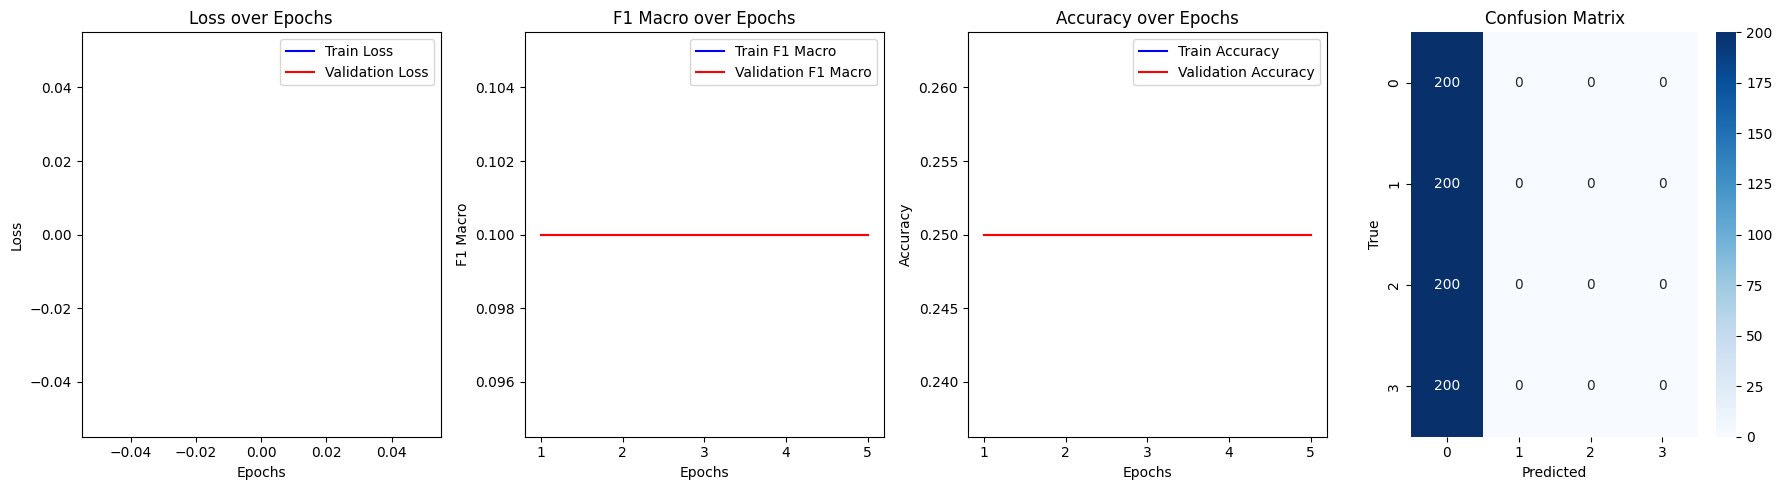

In [20]:
device = 'cuda'
model = cnn().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, 5, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

We notice that the model can not be trained.

**Step 4: Pooling and padding**

In [21]:
# Define Convolutional Neural Network
class cnn_pool(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1,  16,  5, padding=2)
        self.conv2 = nn.Conv2d(16, 32,  5, padding=2)
        self.conv3 = nn.Conv2d(32, 64,  5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        # Fully connected NN layers
        self.fc1   = nn.Linear(1024, 1024)
        self.fc2   = nn.Linear(1024, 256)
        self.fc3   = nn.Linear(256, 32)
        self.fc4   = nn.Linear(32, 4)

        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x):
        # Convolutional layers
        x = self.max_pool(self.conv1(x))
        x = self.max_pool(self.conv2(x))
        x = self.max_pool(self.conv3(x))
        x = self.max_pool(self.conv4(x))
        x = x.view(-1, 1024)
        
        # Fully connected NN layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

Done in 35.67 seconds using GPU


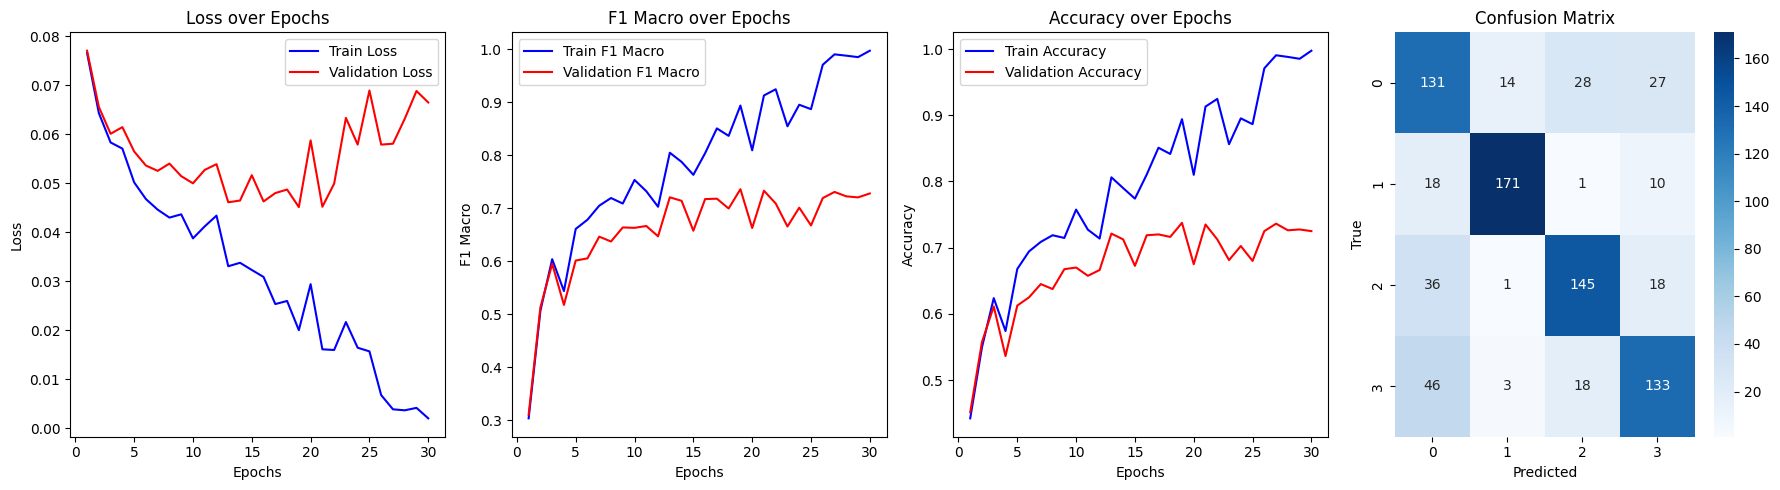

In [22]:
device = 'cuda'
model = cnn_pool().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Step 5: Activation functions**

In [23]:
# Define Convolutional Neural Network
class cnn_relu(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        # Fully connected NN layers
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with ReLU and Max Pooling
        x = self.max_pool(self.relu(self.conv1(x)))
        x = self.max_pool(self.relu(self.conv2(x)))
        x = self.max_pool(self.relu(self.conv3(x)))
        x = self.max_pool(self.relu(self.conv4(x)))
        x = x.view(-1, 1024)
        
        # Fully connected NN layers with ReLU
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Done in 59.24 seconds using GPU


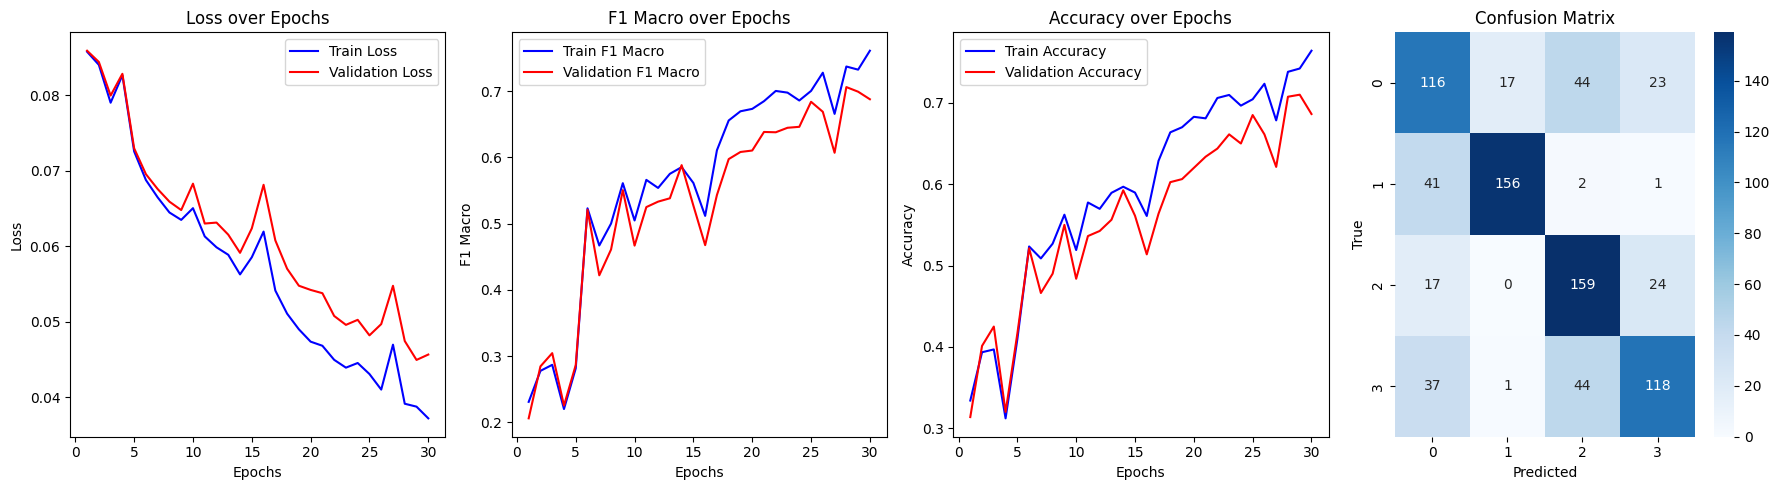

In [24]:
device = 'cuda'
model = cnn_relu().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [25]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_val, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.047474473379552365
Test F1 Macro: 0.7063165142212147
Test Accuracy: 0.7075
Test Confusion Matrix:
 [[126  27  15  32]
 [ 12 183   1   4]
 [ 31   2 122  45]
 [ 41   3  21 135]]


## **Improving Performance**

**Step 1: Reproducibility**

In [26]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

set_seed(0)

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


**Step 2: Testing Optimizers**

More specifically the optimizers I'll be testing are:
- Adam
- Adamax
- Averaged Stochastic Gradient Descent
- Adadelta
- Adagrad
- Resilient Backpropagation

**Adam**

Done in 140.47 seconds using GPU


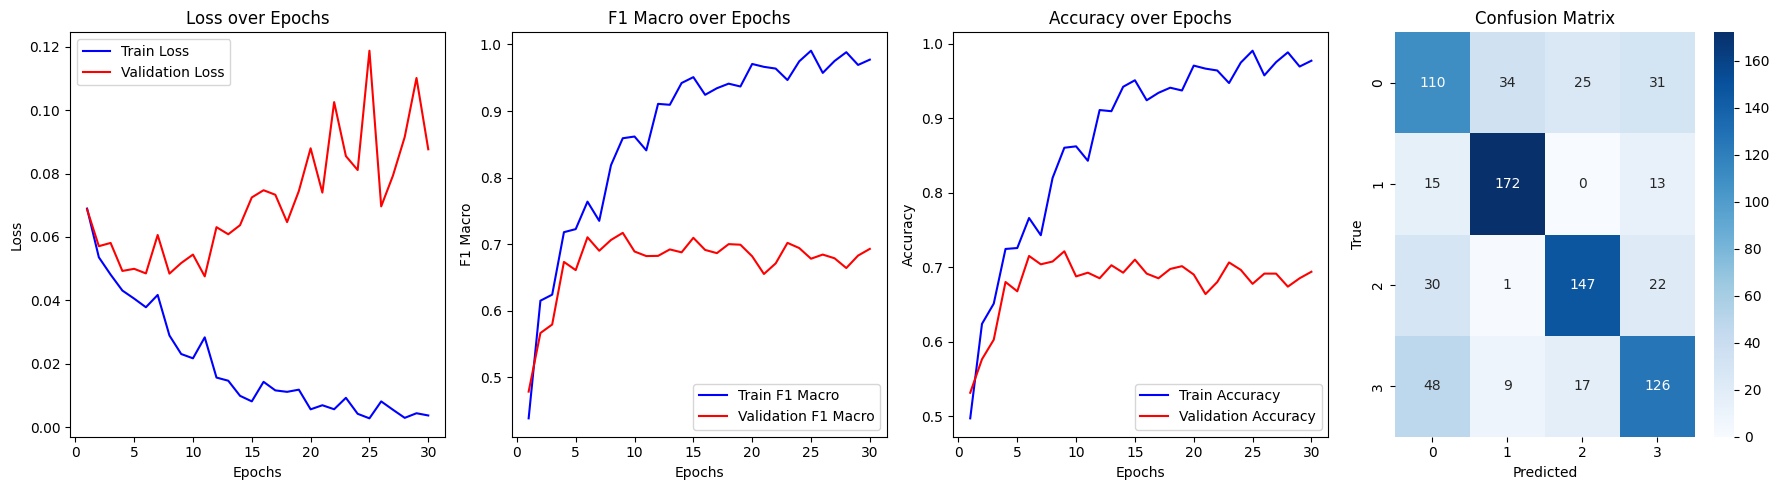

In [27]:
device = 'cuda'
model = cnn_relu().to(device)

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Adamax**

Done in 141.51 seconds using GPU


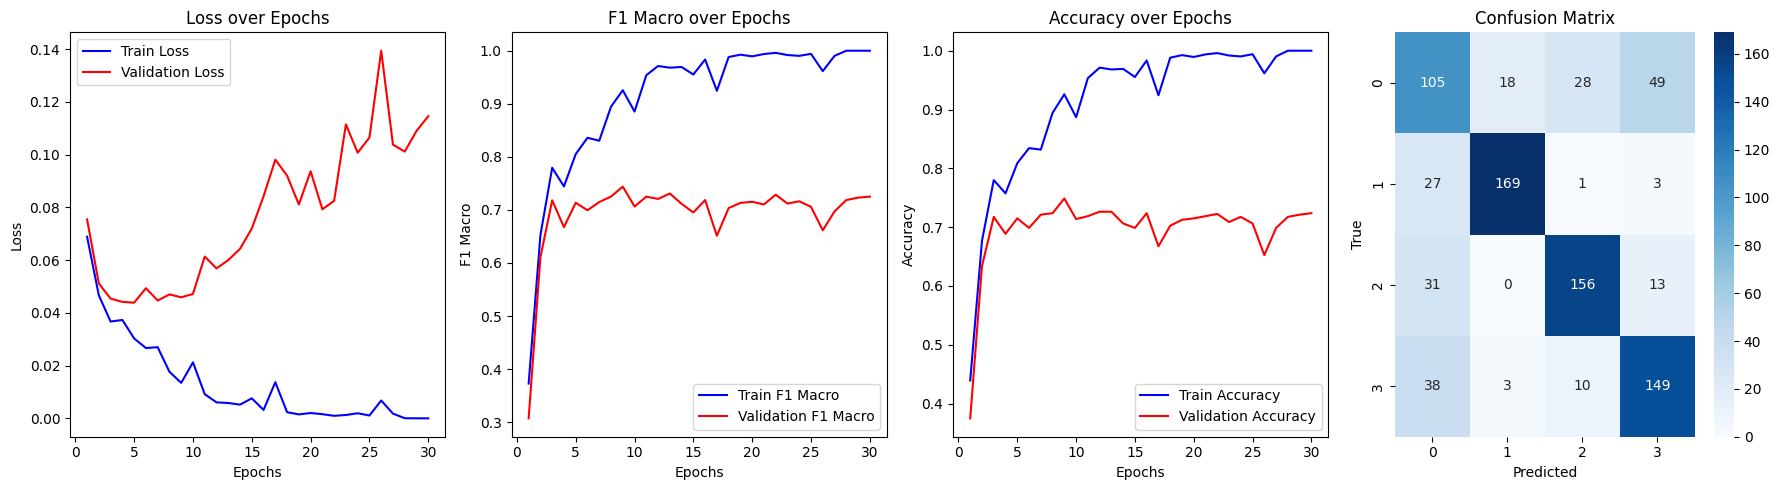

In [28]:
device = 'cuda'
model = cnn_relu().to(device)

# Adamax Optimizer
optimizer = optim.Adamax(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Averaged Stochastic Gradient Descent (ASGD)**

Done in 149.54 seconds using GPU


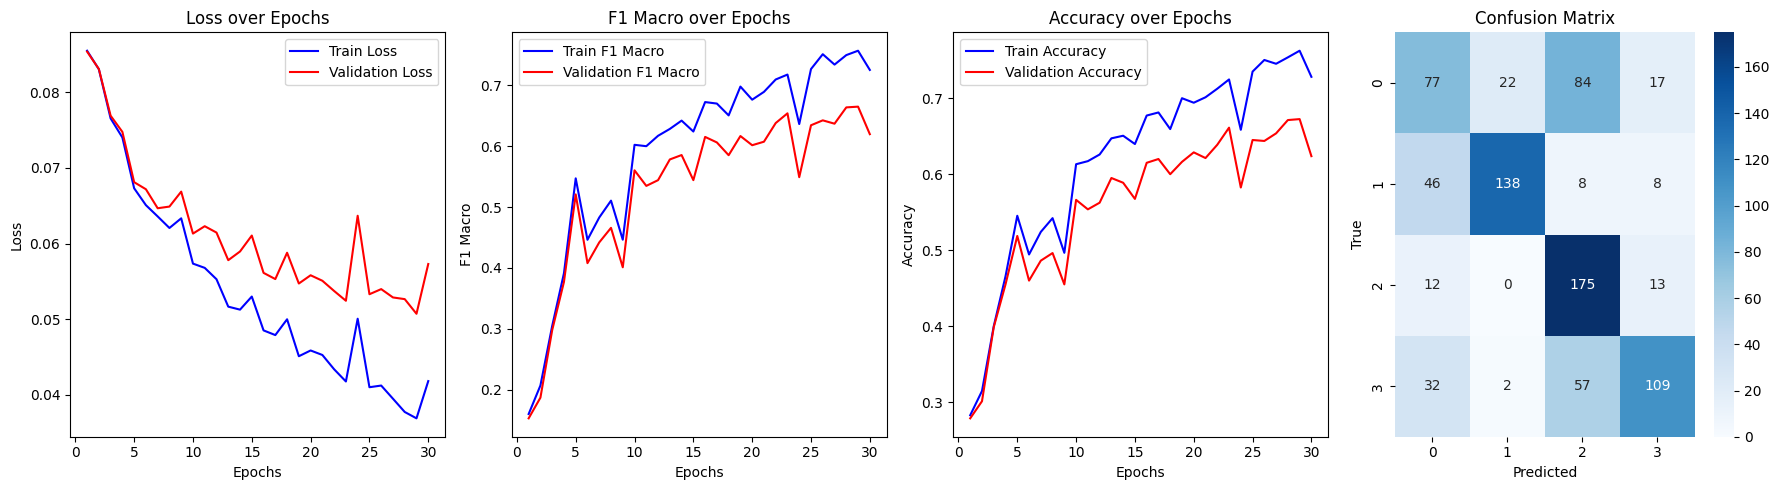

In [29]:
device = 'cuda'
model = cnn_relu().to(device)

# ASGD Optimizer
optimizer = optim.ASGD(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Adadelta**

Done in 151.87 seconds using GPU


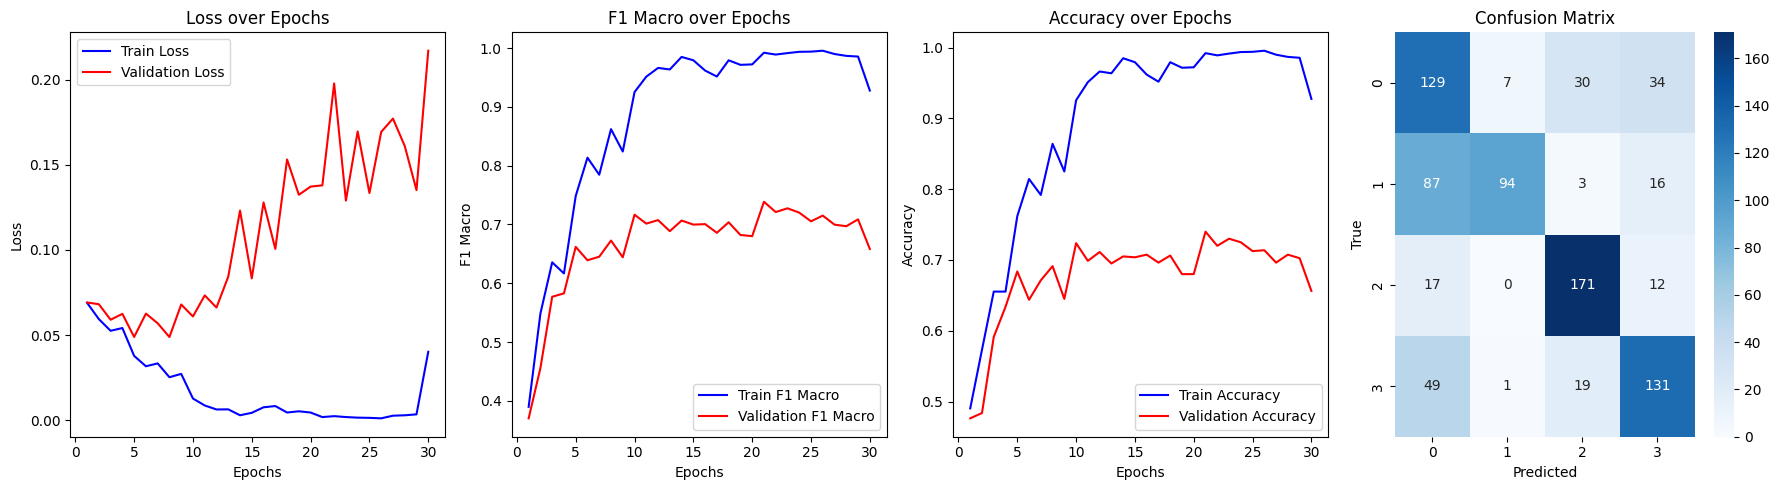

In [30]:
device = 'cuda'
model = cnn_relu().to(device)

# Adadelta Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=1.0)  # lr is not usually needed, but setting default to 1.0
loss_fn = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Adagrad**

Done in 130.91 seconds using GPU


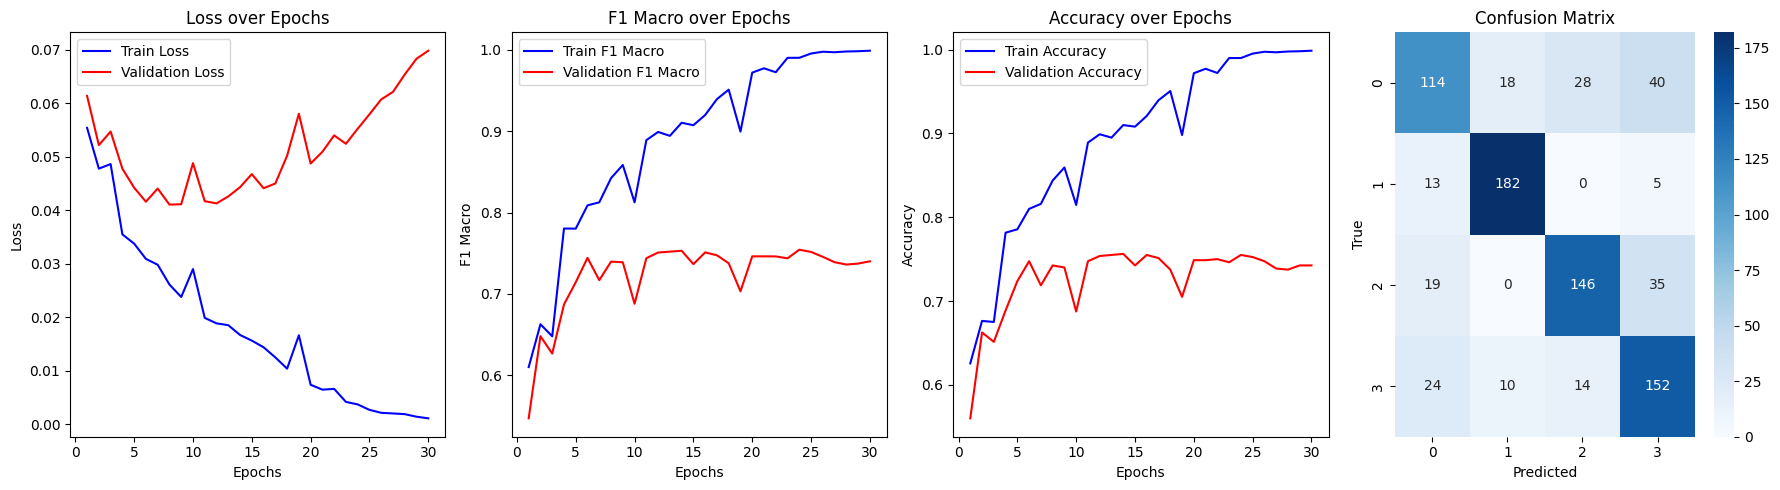

In [31]:
device = 'cuda'
model = cnn_relu().to(device)

# Adagrad Optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Resilient Backpropagation (Rprop)**

Done in 154.47 seconds using GPU


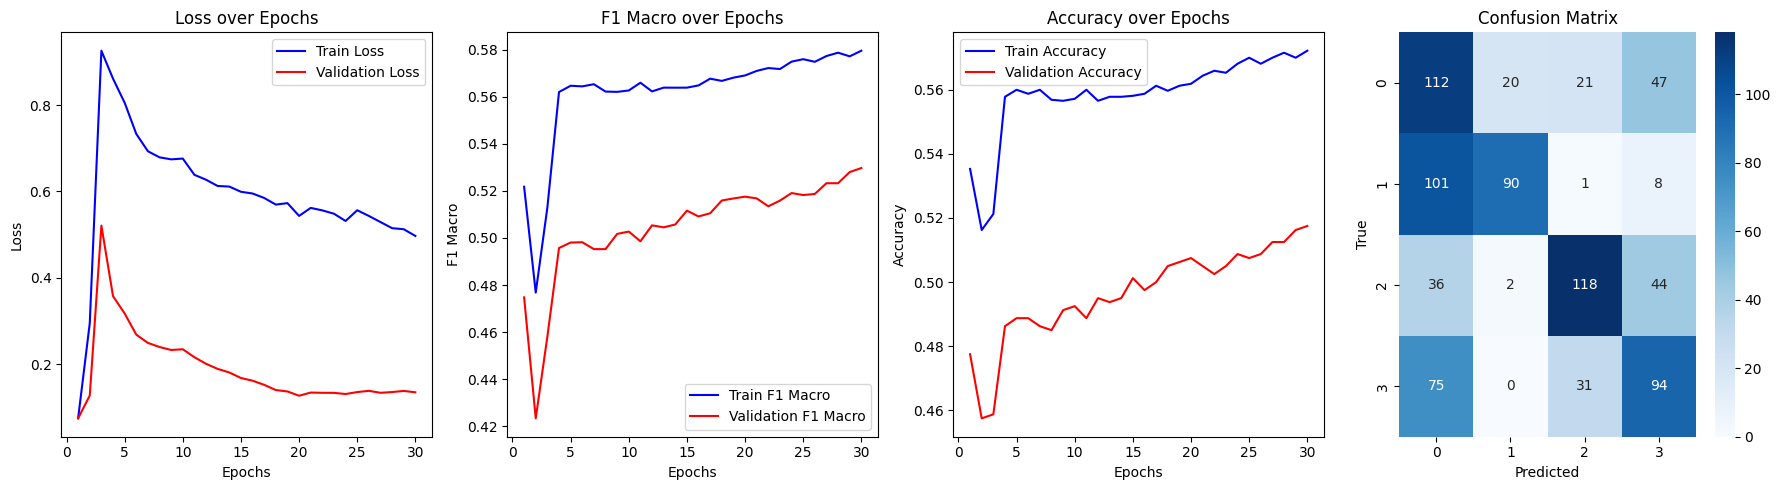

In [32]:
device = 'cuda'
model = cnn_relu().to(device)

# Rprop Optimizer
optimizer = optim.Rprop(model.parameters())
loss_fn = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Step 3: Batch Normalization**

In [33]:
class cnn_batch_norm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  16,  5, padding=2)
        self.conv2 = nn.Conv2d(16, 32,  5, padding=2)
        self.conv3 = nn.Conv2d(32, 64,  5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.fc1   = nn.Linear(1024, 1024)
        self.fc2   = nn.Linear(1024, 256)
        self.fc3   = nn.Linear(256, 32)
        self.fc4   = nn.Linear(32, 4)

        self.norm1 = nn.BatchNorm2d(16)
        self.norm2 = nn.BatchNorm2d(32)
        self.norm3 = nn.BatchNorm2d(64)
        self.norm4 = nn.BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(2)

        self.activ = nn.SELU()

    def forward(self, x):
        # Convolutional layers
        x = self.max_pool(self.activ(self.norm1(self.conv1(x))))
        x = self.max_pool(self.activ(self.norm2(self.conv2(x))))
        x = self.max_pool(self.activ(self.norm3(self.conv3(x))))
        x = self.max_pool(self.activ(self.norm4(self.conv4(x))))
        x = x.view(-1, 1024)
        # Fully connected NN layers
        x = self.activ(self.fc1(x))
        x = self.activ(self.fc2(x))
        x = self.activ(self.fc3(x))
        x = self.fc4(x)
        return x

Done in 138.93 seconds using GPU


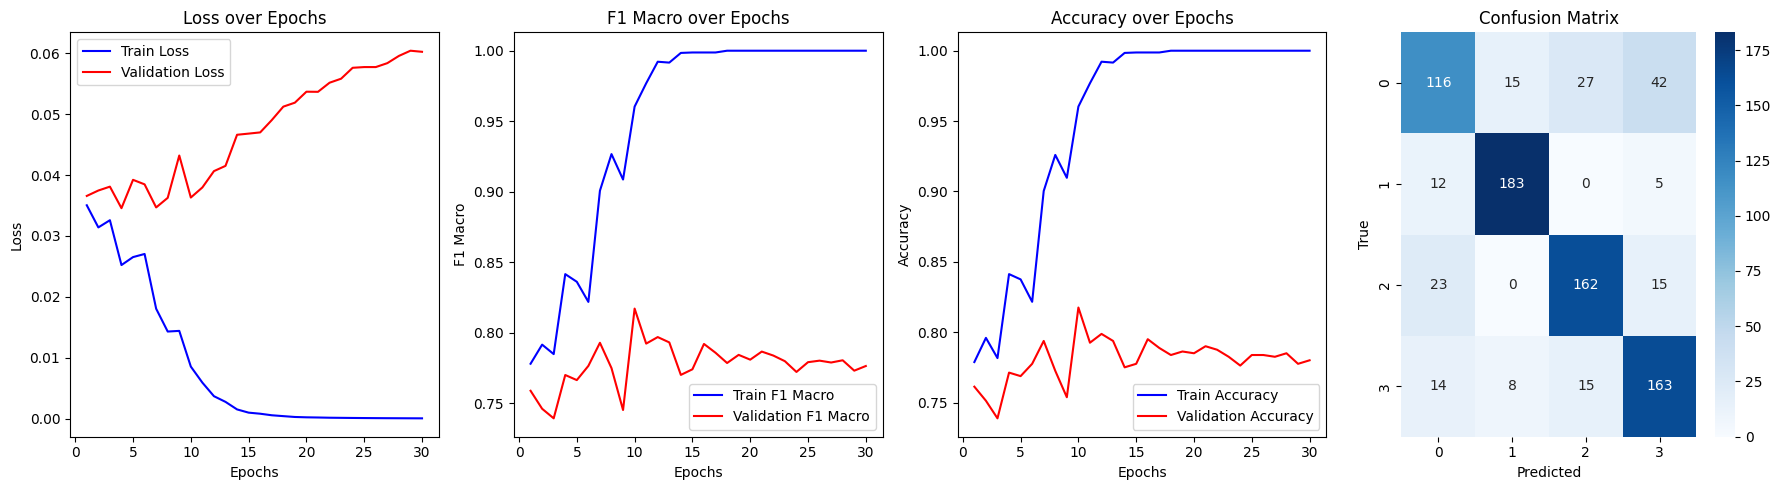

In [34]:
device = 'cuda'
model = cnn_batch_norm().to(device)

# Rprop Optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Step 4: Regularization**

In [35]:
dropout = None

In [36]:
# Define Convolutional Neural Network
class cnn_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  16,  5, padding=2)
        self.conv2 = nn.Conv2d(16, 32,  5, padding=2)
        self.conv3 = nn.Conv2d(32, 64,  5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.fc1   = nn.Linear(1024, 1024)
        self.fc2   = nn.Linear(1024, 256)
        self.fc3   = nn.Linear(256, 32)
        self.fc4   = nn.Linear(32, 4)
        self.drop = nn.Dropout(dropout)

        self.max_pool = nn.MaxPool2d(2)

        self.norm1 = nn.BatchNorm2d(16 )
        self.norm2 = nn.BatchNorm2d(32 )
        self.norm3 = nn.BatchNorm2d(64 )
        self.norm4 = nn.BatchNorm2d(128)

        self.activ = nn.SELU()

    def forward(self, x):
        # Convolutional layers
        x = self.max_pool(self.activ(self.norm1(self.conv1(x))))
        x = self.max_pool(self.activ(self.norm2(self.conv2(x))))
        x = self.max_pool(self.activ(self.norm3(self.conv3(x))))
        x = self.max_pool(self.activ(self.norm4(self.conv4(x))))
        x = x.view(-1, 1024)
        # Fully connected NN layers
        x = self.drop(self.activ(self.fc1(x)))
        x = self.drop(self.activ(self.fc2(x)))
        x = self.drop(self.activ(self.fc3(x)))
        x = self.drop(self.fc4(x))
        return x

**Dropout p = 0.1**

Done in 289.21 seconds using GPU


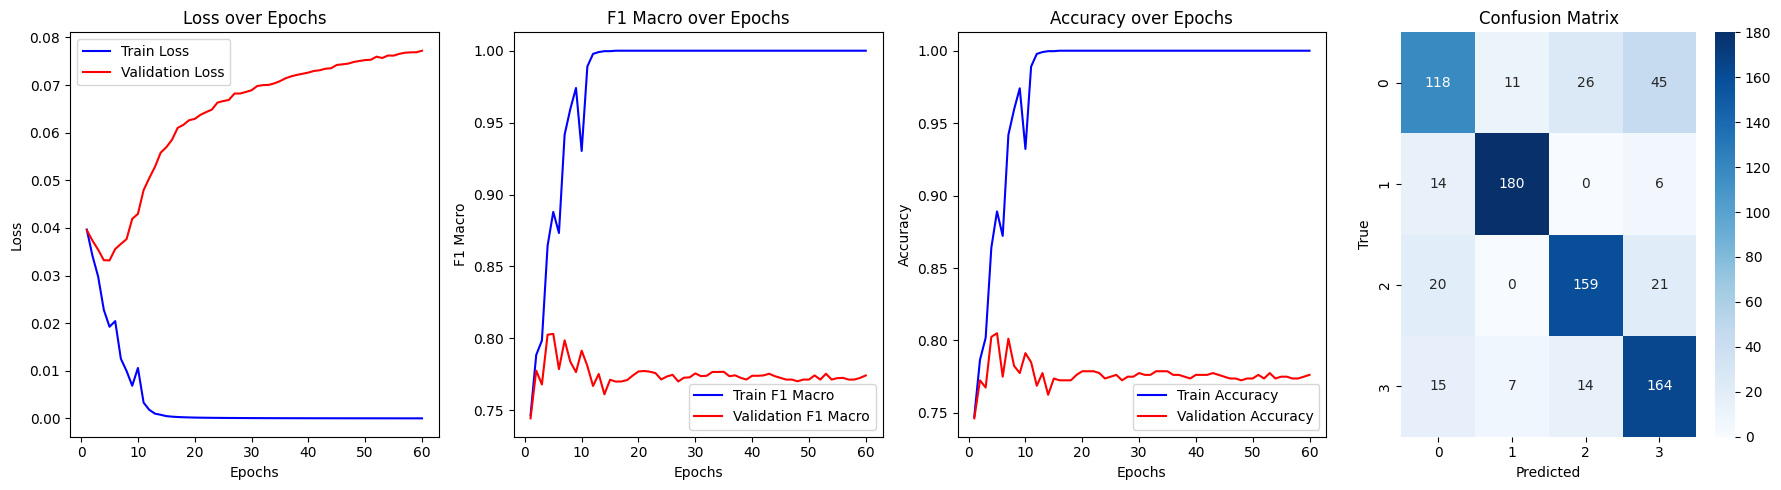

In [37]:
device   = 'cuda'
dropout  = 0.1
epochs_n = 60
model   = cnn_dropout().to(device)

# Rprop Optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.002)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

**Dropout p = 0.2**

Done in 289.71 seconds using GPU


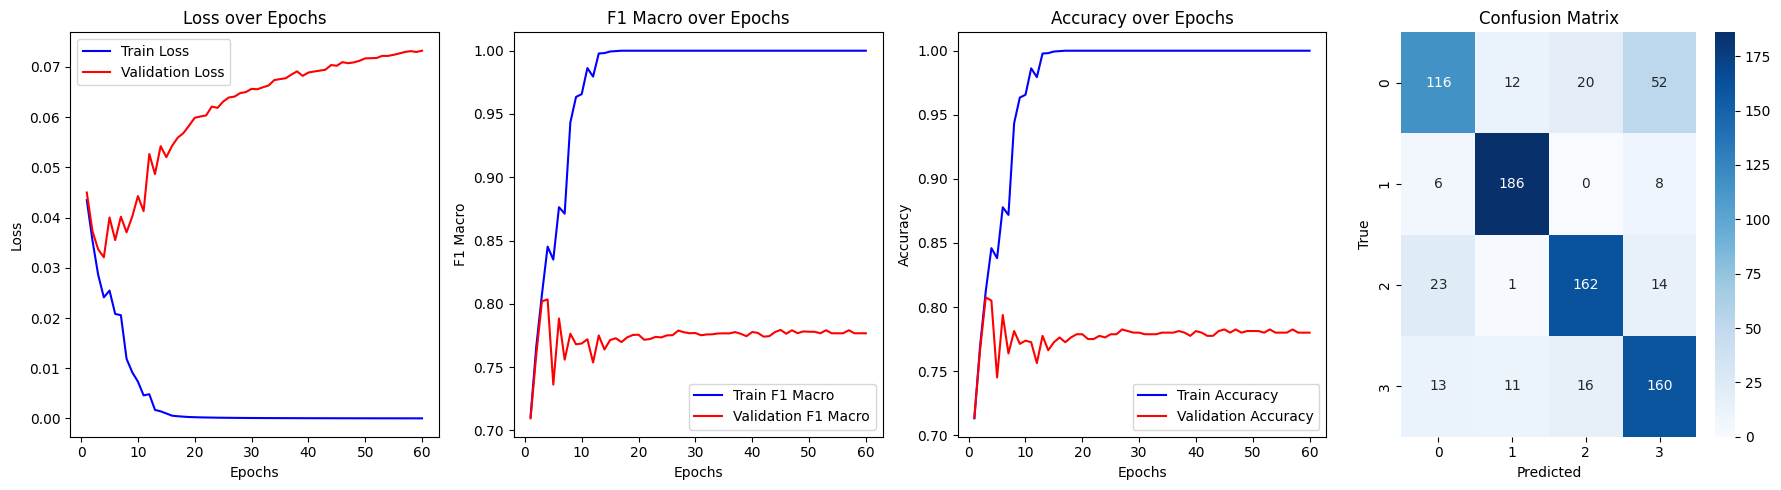

In [38]:
device = 'cuda'
dropout = 0.2
model   = cnn_dropout().to(device)

# Rprop Optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.002)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [39]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_val, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.03209319420158863
Test F1 Macro: 0.8034483613814223
Test Accuracy: 0.805
Test Confusion Matrix:
 [[135  16  24  25]
 [  8 189   0   3]
 [ 24   1 162  13]
 [ 23   6  13 158]]


**Dropout p = 0.3**

Done in 288.50 seconds using GPU


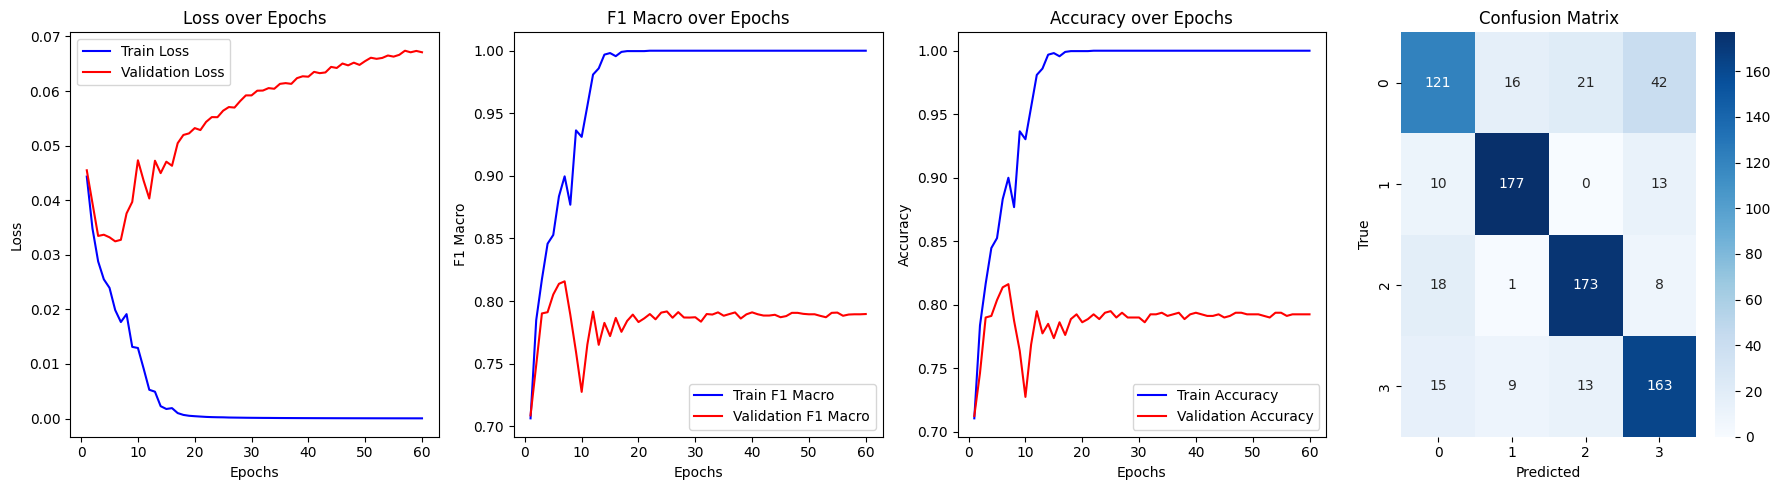

In [40]:
device = 'cuda'
dropout = 0.3
model   = cnn_dropout().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=0.002)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [41]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_val, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.032742339074611666
Test F1 Macro: 0.8157912115662125
Test Accuracy: 0.81625
Test Confusion Matrix:
 [[151  20  14  15]
 [  7 188   0   5]
 [ 28   1 161  10]
 [ 25  10  12 153]]


**Dropout p = 0.4**

Done in 273.17 seconds using GPU


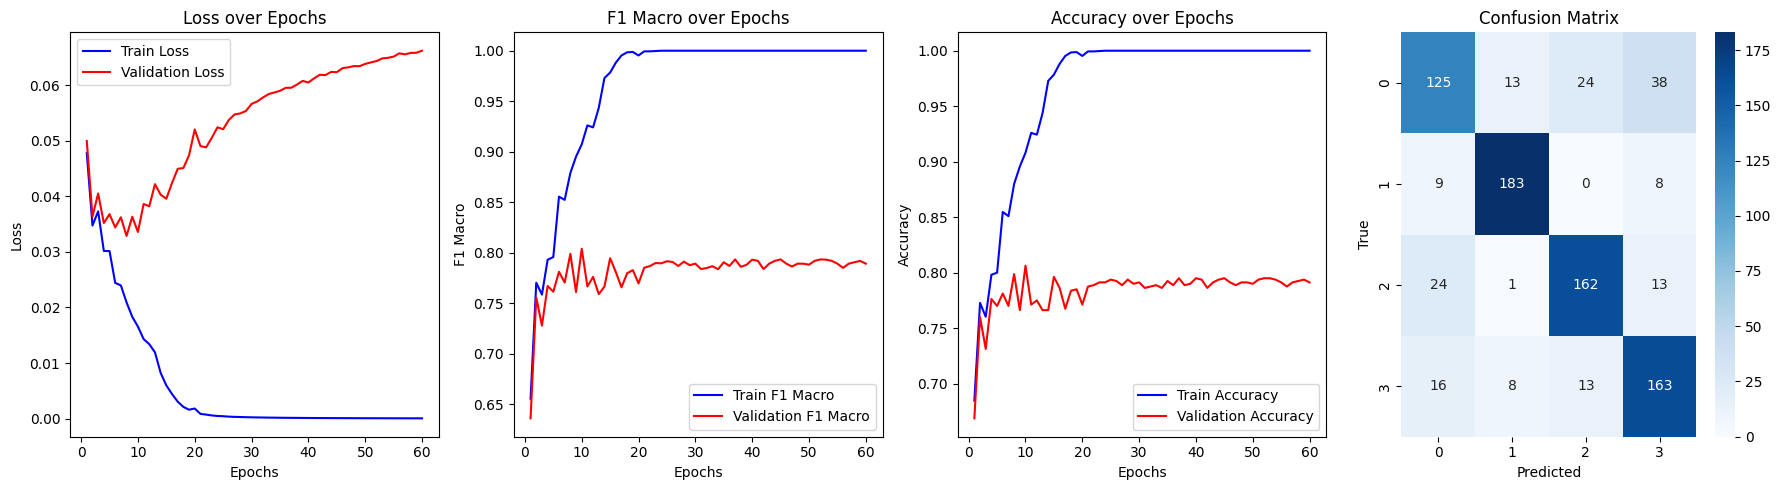

In [42]:
device = 'cuda'
dropout = 0.4
model   = cnn_dropout().to(device)

# Rprop Optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.002)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [43]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_test, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.037849307090995314
Test F1 Macro: 0.781488603977759
Test Accuracy: 0.779796511627907
Test Confusion Matrix:
 [[207  23  32  62]
 [  4 287   1   5]
 [ 40   2 298  16]
 [ 73  17  28 281]]


Done in 272.53 seconds using GPU


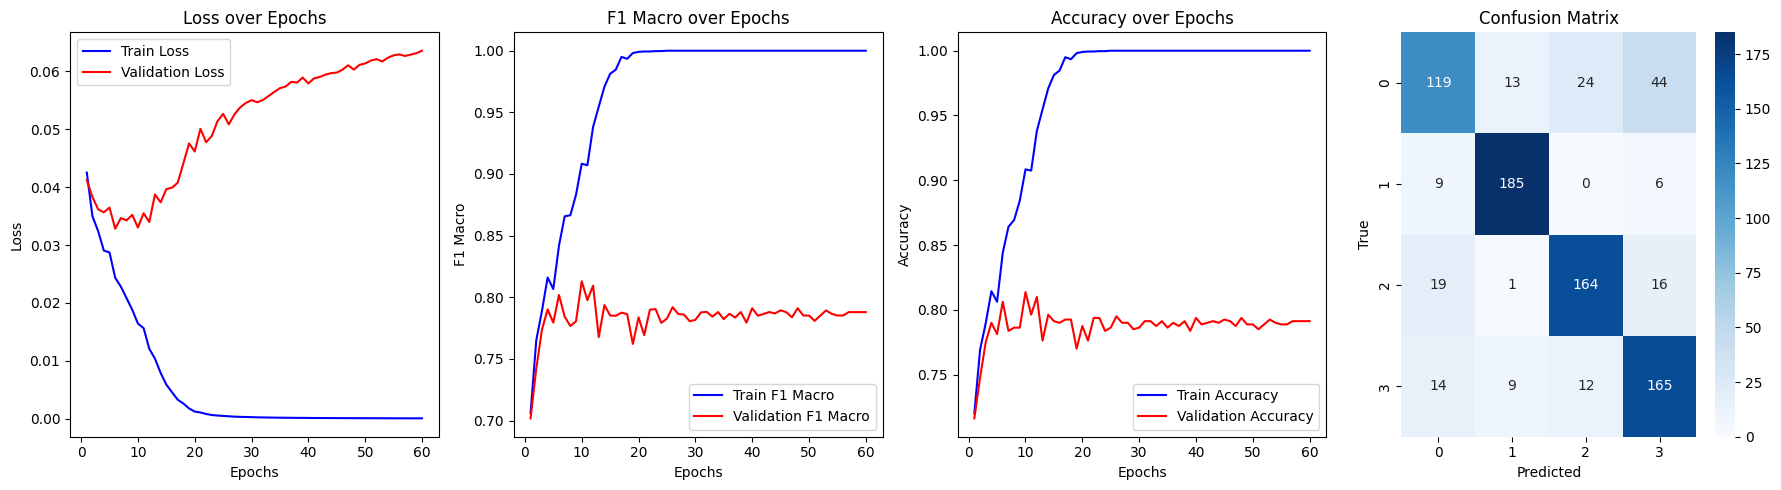

In [44]:
device = 'cuda'
dropout = 0.4
model   = cnn_dropout().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=0.002)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [45]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_val, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.033029139954596755
Test F1 Macro: 0.8129991921742166
Test Accuracy: 0.81375
Test Confusion Matrix:
 [[145  16  15  24]
 [ 10 188   0   2]
 [ 26   1 158  15]
 [ 19   9  12 160]]


**Weight decay 0.01**

Done in 282.48 seconds using GPU


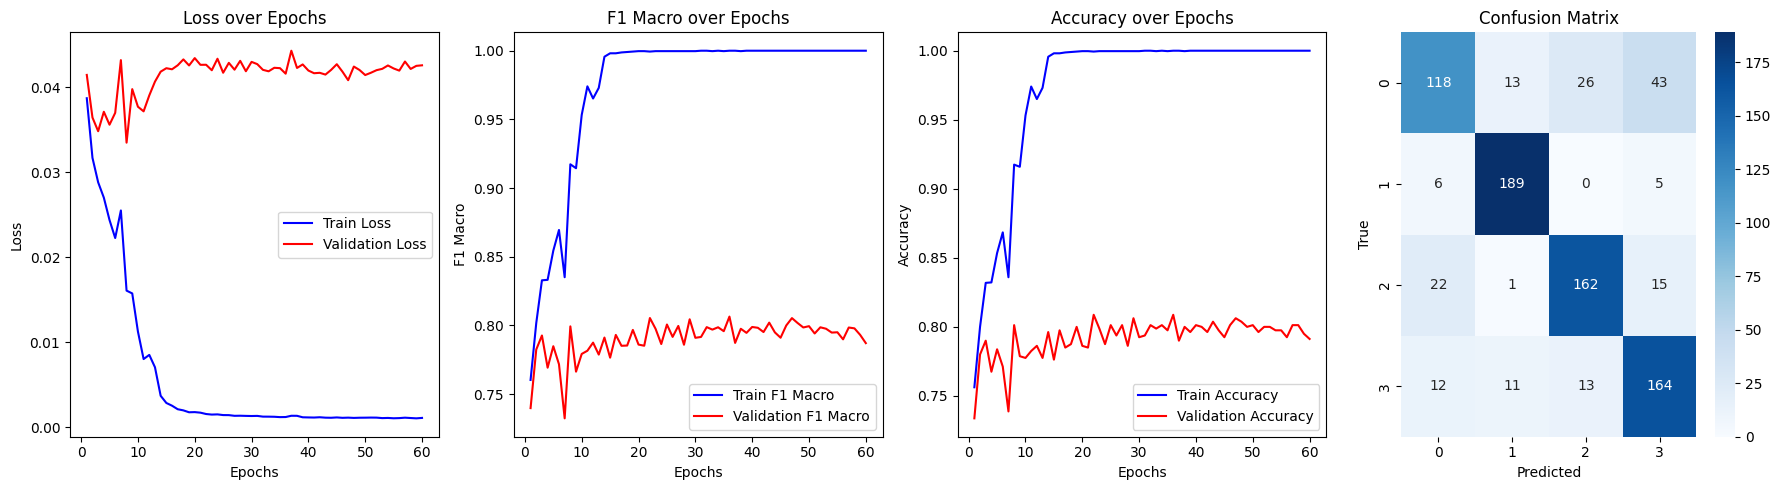

In [46]:
device = 'cuda'
dropout = 0.4
model   = cnn_batch_norm().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=0.002, weight_decay=0.01)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [47]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_test, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.05104970523427974
Test F1 Macro: 0.7741251864666346
Test Accuracy: 0.7732558139534884
Test Confusion Matrix:
 [[194  18  31  81]
 [  8 284   1   4]
 [ 32   5 297  22]
 [ 62  19  29 289]]


**Weight decay 0.075**

Done in 277.44 seconds using GPU


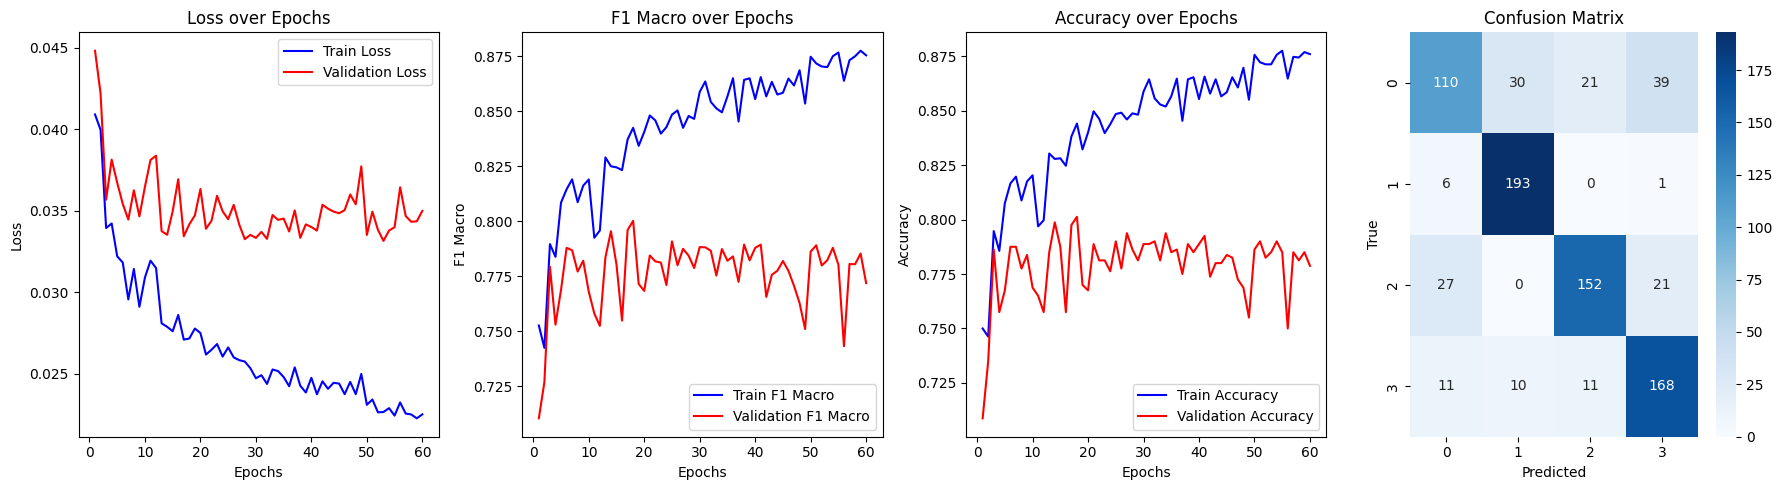

In [48]:
device = 'cuda'
dropout = 0.4
model   = cnn_batch_norm().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=0.002, weight_decay=0.075)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [49]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_val, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.03417513765394688
Test F1 Macro: 0.8002388156520889
Test Accuracy: 0.80125
Test Confusion Matrix:
 [[134  12  21  33]
 [ 11 186   0   3]
 [ 22   1 164  13]
 [ 23   7  13 157]]


**Weight decay 0.01 + dropout 0.4**

Done in 282.56 seconds using GPU


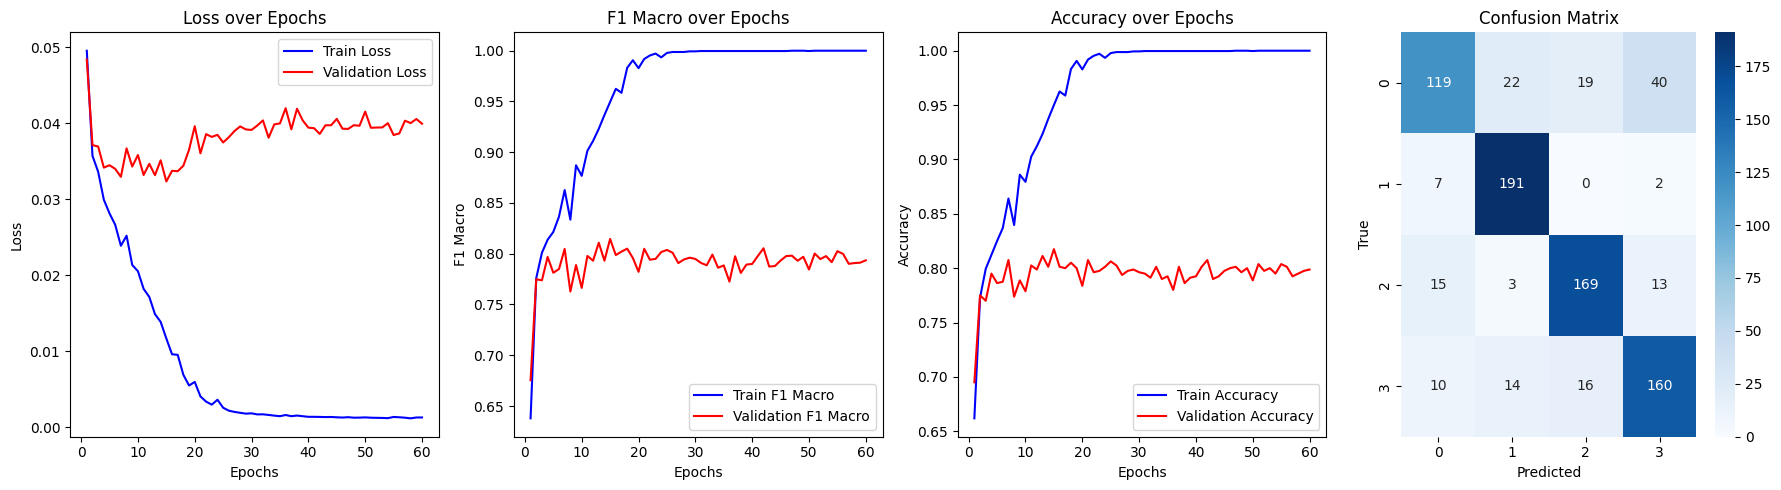

In [50]:
device = 'cuda'
dropout = 0.4
model   = cnn_dropout().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=0.002, weight_decay=0.01)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [51]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_val, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.03234615160152316
Test F1 Macro: 0.8145627666050117
Test Accuracy: 0.8175
Test Confusion Matrix:
 [[134  15  26  25]
 [ 10 189   0   1]
 [ 14   2 176   8]
 [ 16  10  19 155]]


**Weight decay 0.075 + dropout 0.4**

Done in 200.67 seconds using GPU


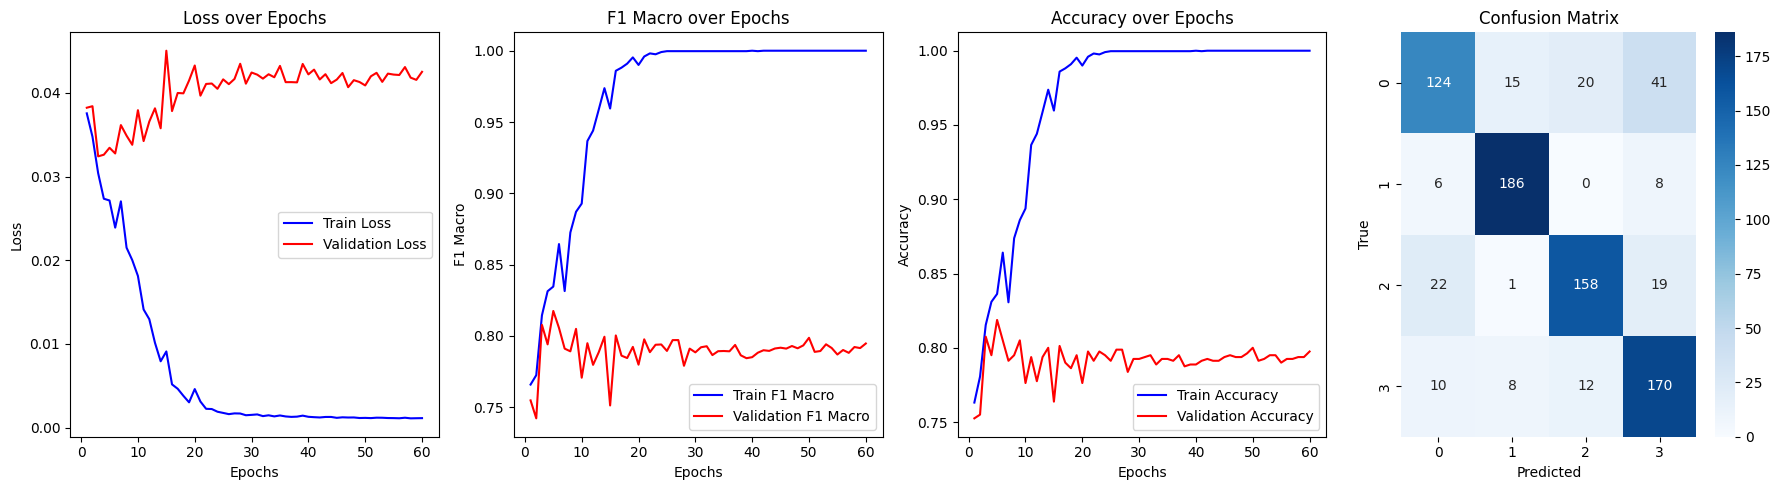

In [52]:
device = 'cuda'
dropout = 0.075
model   = cnn_dropout().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=0.002, weight_decay=0.01)
loss_fn   = nn.CrossEntropyLoss()

best_model, tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix = train_nn(model, epochs_n, optimizer, dl_train, dl_val, loss_fn)
plot_results(tr_losses, val_losses, epochs, tr_scores, val_scores, tr_accuracies, val_accuracies, conf_matrix)

In [53]:
test_loss, test_f1_macro, test_accuracy, test_conf_matrix = test_nn(best_model, dl_test, loss_fn)
print("Test Loss:", test_loss)
print("Test F1 Macro:", test_f1_macro)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)

Test Loss: 0.03775958489419535
Test F1 Macro: 0.7781854587900446
Test Accuracy: 0.7732558139534884
Test Confusion Matrix:
 [[254  20  28  22]
 [  5 291   0   1]
 [ 57   5 279  15]
 [115  23  21 240]]


We notice that our best performing model is:
- Adagrad optimizer
- CrossEntropyLoss
- Weight decay = 0.075
- Dropout = 0.4

## **Testing**

**Step 1: Inference**

In [54]:
import numpy as np
import librosa
from pytube import YouTube
from pytube.exceptions import VideoUnavailable
from pydub import AudioSegment
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

def get_predictions(melgrams, model):
    model.eval()
    model.to(device)
    predictions = []
    with torch.no_grad():
        for melgram in melgrams:
            melgram = torch.tensor(melgram).unsqueeze(0).unsqueeze(0).to(device)
            outputs = model(melgram)
            _, predicted = torch.max(outputs, 1)
            predictions.append(predicted.cpu().numpy()[0])
    return predictions

**Step 2: Download music from youtube**

In [55]:
def youtube_to_melgram(url):
    try:    
        yt = YouTube(url)
        audio_stream = yt.streams.filter(only_audio=True).first()
        audio_file = audio_stream.download(filename='audio.mp4')
        audio = AudioSegment.from_file(audio_file, format="mp4")
        audio.export("audio.wav", format="wav")
        y, sr = librosa.load("audio.wav", sr=None)
        hop_length = sr
        melgrams = []
        for i in range(0, len(y), hop_length):
            y_segment = y[i:i + hop_length]
            if len(y_segment) == hop_length:
                melgram = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_mels=128)
                melgrams.append(melgram)
        melgrams = np.array(melgrams)
        return melgrams
    except VideoUnavailable:
        print(f"Video at {url} is unavailable.")
        return None

**Step 3: Predictions**

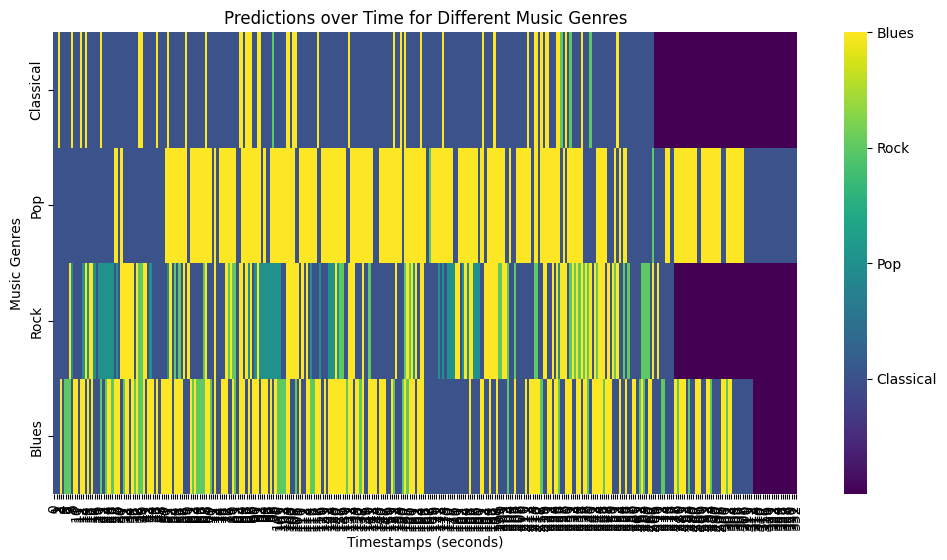

In [56]:
urls = {
    "Classical": "https://www.youtube.com/watch?v=9E6b3swbnWg",
    "Pop": "https://www.youtube.com/watch?v=EDwb9jOVRtU",
    "Rock": "https://www.youtube.com/watch?v=hTWKbfoikeg",
    "Blues": "https://www.youtube.com/watch?v=l45f28PzfCI"
}

# Λίστα με τις προβλέψεις για κάθε μουσικό είδος
all_predictions = {}
max_length = 0

for genre, url in urls.items():
    melgrams = youtube_to_melgram(url)
    if melgrams is not None:
        predictions = get_predictions(melgrams, model)
        all_predictions[genre] = predictions
        if len(predictions) > max_length:
            max_length = len(predictions)

# Δημιουργία του heatmap
prediction_matrix = np.full((len(urls), max_length), -1)  # Χρησιμοποιούμε -1 για να υποδηλώσουμε έλλειψη δεδομένων

for i, (genre, predictions) in enumerate(all_predictions.items()):
    prediction_matrix[i, :len(predictions)] = predictions

# Δημιουργία του heatmap με σωστή χαρτογράφηση των χρωμάτων
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(prediction_matrix, annot=False, cmap="viridis", xticklabels=range(max_length), yticklabels=list(urls.keys()), cbar=True)
cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(["Classical", "Pop", "Rock", "Blues"])
plt.xlabel('Timestamps (seconds)')
plt.ylabel('Music Genres')
plt.title('Predictions over Time for Different Music Genres')
plt.show()

We notice:

- Classical music has a very distinct style, the model correctly predicts the label in all the duration.
- We notice the model does not identify pop correctly, misinterpreting a lot with Blues.
- There are several timestamps where rock is identified correctly, however the performance of the model is not stable enough for this class.
- Blues is mostly identified correctly. 